## Class imbalance ⚖️ : Cost-sensitive Learning 🔨💰
                                          

In [1]:
import pandas as pd
import numpy as np
from numpy import where, unique, hstack, vstack 

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## I. What is class imbalance and why could it be a problem for making predictions?

In [2]:
# generate dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=42, cluster_std=3)

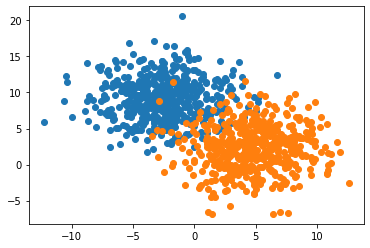

In [3]:
# create scatter plot for samples from each class
for class_value in range(2):
	row_ix = where(y == class_value)             # get row indexes for samples with this class
	plt.scatter(X[row_ix, 0], X[row_ix, 1])      # create scatter of these samples
plt.show()

In [4]:
proportions = {0:10000, 1:1000} 

def get_dataset(proportions):
	"""create a dataset with a given class distribution"""
	n_classes = len(proportions)                                # determine the number of classes
	largest = max([v for k,v in proportions.items()])           # determine the number of examples to generate for each class
	n_samples = largest * n_classes
	X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=2, random_state=42, cluster_std=3)
	X_list, y_list = list(), list()                             # collect the examples
	for k,v in proportions.items():
		row_ix = where(y == k)[0]
		selected = row_ix[:v]
		X_list.append(X[selected, :])
		y_list.append(y[selected])
	return vstack(X_list), hstack(y_list)


def plot_dataset(X, y):
	"""create scatter plot for samples from each class"""
	n_classes = len(unique(y))
	for class_value in range(n_classes):
		row_ix = where(y == class_value)[0]                      # get row indexes for samples with this class
		plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(class_value))  # create scatter of these samples
	plt.legend()                                                 # show a legend
	plt.show()                                  

### Compare this to an "imbalanced" dataset:

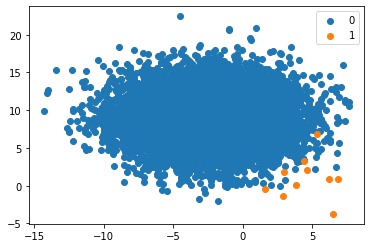

In [5]:
proportions = {0:10000, 1:10} # i.e.: for each "1" instance, there are 1.000 "0" instances                   
X, y = get_dataset(proportions)                     
plot_dataset(X, y)                                  

- if ratio majority class instances/minority class instances > 1 => "class imbalance"

Taking creditcard dataset (see kaggle: https://www.kaggle.com/c/GiveMeSomeCredit/data)

In [6]:
df = pd.read_csv("../data/creditcard.zip", index_col=0)
df["Class"].unique()

array([0, 1])

In [7]:
X = df.iloc[:,:-1] 
y = df["Class"]
X.shape, y.shape 

((284807, 27), (284807,))

In [8]:
df["Class"].value_counts() / df.shape[0]

0    0.998273
1    0.001727
Name: Class, dtype: float64

- **Because** of class imbalance in the dataset, **any model will be a lot more exposed to the majority class** => predictions will be biased towards predicting negative class for future instances
- In fact, just by looking at the distribution, we could easily set up a **no skill model** generalizing that **there a NO fraud cases**

#### ...but what's the "price" we pay for using this (admittedly trivial) model? 
- in practice:
    - consider the loss that one single, big fraud case can generate for a financial institution as a whole (e.g. thru so-called "Loan Loss Provisions" eating up profits)
    - unfortunately, in the pandemic we have also learned first-hand what negative consequences a false prediction of **negatives** can have...

#### So, "no skill" model doesn't seem very convincing...but let's give it a chance evaluating it with a formal metric such as "accuracy".

$$ accuracy = (TP+TN)/(TP+FP+TN+FN)$$ 

In [9]:
y_pred = np.zeros(y.shape[0])

In [10]:
accuracy_score(y, y_pred).round(3)

0.998

## Accuracy actually indicates that "no skill"-model performs quite well! 🤔
- => **underlying assumption** is that **number of correct predictions** should be **maximized**
- => instead, you should evaluate binary classification models by **how well they distinguish between classes**, which lies at the center of "ranking metrics" (e.g. ROC)

## II. How can we deal with the challenge of bias of our model towards majority class? 
## => apply cost-sensitive learning 🔨💰!!

#### "Cost-sensitive learning (...) takes the costs of prediction errors (...) into account when training a machine learning model. (...) many conceptualizations and techniques developed and used for cost-sensitive learning can be adopted for imbalanced classification problems."  - Jason Brownlee 

- Let's fit a simple **LogReg model** 
- with the following **cost function**:

$$ cost(ypred_{i}, y_{i}) = - (log(ypred_{i}) * y_{i} + log(1 - ypred_{i}) * (1 - y_{i}))$$ 

In [11]:
X = X.copy() 
y = y.copy()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) # remember: you set "stratify" so that train data and labelled data have the same "proportions" re classes...
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((213605, 27), (71202, 27), (213605,), (71202,))

In [13]:
LogReg_unweighted = LogisticRegression(random_state=42, class_weight=None)  # instantiating model - default weighting 

- LogReg() can take several parameters, includig "class_weight" 
- if "class_weight" is not defined otherwise, **LogReg() will assume equally proportional penalties for errors**!

In [14]:
LogReg_unweighted.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [15]:
y_pred = LogReg_unweighted.predict(X_test)

In [16]:
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
print(f"Area Under Curve: {roc_auc_score(y_test, y_pred).round(2)}")

Confusion Matrix: 
[[71052    27]
 [   49    74]]
Area Under Curve: 0.8


In [17]:
Ratio_TP = 74/123*100
Ratio_TP

60.16260162601627

## Intuition ROC 
- intuition ROC: a **curve** of **combinations** of **FP-rate** (x-axis) and **TP-rate** (y-axis) for a set of predictions by a classifier **for different thresholds**
- note the **trade-off** between TP-rates and FP-rates (i.e. the **shape of the curve**)
- helpful for evaluating **one model** (binary classification) **under different thresholds**

## Intuition ROC AUC
- intuition **AUC**: the **score** resulting from **area** below ROC
- more precisely: probability, that the scores given by a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one
- helpful for evaluating **more than one model to each other** (binary classification)

## Enter the cost-sensitized LogReg classifier
- LogReg algo can be modified to be better suited for imbalanced classification by means of introducing weights:
    - the weighting can **penalize the model less** for **errors made on examples from the majority class** and penalize the model **more for errors made on examples from the minority class**.
    - a **larger weight** value results in a **larger error calculation**, and in turn, **more update** to the model **coefficients** (and vice versa)

$$ cost(ypred_{i}, y_{i}) = - (w_{0} * log(ypred_{i}) * y_{i} + w_{1} * log(1 - ypred_{i}) * (1 - y_{i}))$$ 

In [18]:
weights = {0:0.02, 1:0.98} # tuning weights... 

- **"not all misclassification errors should be treated as equals"**
- if classifier has missed the minority class => multiply penalty by 0.998
- if classifier has missed the majority class => multiply penalty by 0.002
- note that the set weights correspond to the **inversed class ratio**

In [19]:
LogReg_weighted = LogisticRegression(random_state=42, class_weight=weights) # note explicit spec of "weights" param!

In [20]:
LogReg_weighted.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.02, 1: 0.98}, random_state=42)

In [21]:
y_hat_weighted = LogReg_weighted.predict(X_test)

In [22]:
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_hat_weighted)}")
print(f"Area Under Curve: {roc_auc_score(y_test, y_hat_weighted).round(2)}")

Confusion Matrix: 
[[70644   435]
 [   27    96]]
Area Under Curve: 0.89


In [23]:
Ratio_TP = 96/123*100
Ratio_TP

78.04878048780488

In [24]:
weights = {0:1, 1:10} 

In [25]:
LogReg_weighted = LogisticRegression(random_state=42, class_weight=weights)

In [26]:
LogReg_weighted.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42)

In [27]:
y_hat_weighted = LogReg_weighted.predict(X_test)

In [28]:
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_hat_weighted)}")
print(f"Area Under Curve: {roc_auc_score(y_test, y_hat_weighted).round(2)}")

Confusion Matrix: 
[[70984    95]
 [   30    93]]
Area Under Curve: 0.88


In [29]:
Ratio_TP = 93/123*100
Ratio_TP

75.60975609756098

In [30]:
p = pd.DataFrame ({
    "Metric": ["AUC","Ratio_TP"],
    "Vanilla_LogReg": [0.80, 0.60],
    "Cost_Weighted_LogReg": [0.89, 0.78],
    "Cost_Weighted_OM_LogReg": [0.88, 0.76]
    })

In [31]:
p.set_index("Metric")

,Vanilla_LogReg,Cost_Weighted_LogReg,Cost_Weighted_OM_LogReg
Metric,,,
AUC,0.8,0.89,0.88
Ratio_TP,0.6,0.78,0.76


Clearly, cost-sensitive learning leads to better results (based on ROC AUC)!